# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Determinación-de-los-parámetros-de-los-retardadores" data-toc-modified-id="Determinación-de-los-parámetros-de-los-retardadores-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Determinación de los parámetros de los retardadores</a></div><div class="lev2 toc-item"><a href="#Parte-experimental" data-toc-modified-id="Parte-experimental-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Parte experimental</a></div><div class="lev2 toc-item"><a href="#Fitting-to-matrices:-solo-angulos" data-toc-modified-id="Fitting-to-matrices:-solo-angulos-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Fitting to matrices: solo angulos</a></div>

# Determinación de los parámetros de los retardadores

**Autor**: Jesus del Hoyo Muñoz

**Fecha**:   27/07/2018

**Objetivo**: Ecograb project, polariscope callibration

**Configuración**:

1. Diodo láser de Roithner .... de longitud de onda $\lambda$=850 nm (corriente = 314 mA).
1. Lente colimadora de Thorlabs DG10-600-B.
1. Difusor.
1. Lámina retardadora $\lambda/4$ ... de Throlabs para hacer el haz de luz circular.
1. Polarizador 1 Thorlabs LPNIRE100-B.
1. Retardador  2 $\lambda/4$ Thorlabs WPQ10E-850-SP
1. Divisor de haz Thorlabs CCM1-BS014/M.
1. Retardador  2 $\lambda/4$ Thorlabs WPQ10E-850-SP
1. Polarizador 4 Thorlabs LPNIRE100-B.




**Procedimiento**:

Se conocen los parámetros y ángulos de P1 y P4. Están cruzados a 0 y 90 grados. Tambien los parámetros de los retardadores y del divisor de haz, pero es posible que del último haya que ajustarlos.

1. Se interpone las láminas retardadoras R1 y  R2

1. Se deja P1 y P2 en un ángulo fijo.

1. Se hace un doble bucle for para R1 y R2.



**Resultado**

1. Posición del ángulo de R1 y R2.
1. Comprobar que el experimento funciona



In [1]:
from __future__ import print_function, division

# configuration
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [6]:
# import modules
from phyton_optics import sp, plt, mm, um, nm, degrees, np
import phyton_optics.polarization_stokes as polarization
from phyton_optics.polarization_stokes import (
    intensity, polarized_light, polarizer_linear, quarter_waveplate, rotate_mueller, 
    diattenuating_retarder, retarder, vacuum)

from polarimeter.polarimeter import (get_polarimeter_parameters, polarimeter_matrices,
    rotate_polarimeter, polarimeter_matrix, get_light_parameters)
from polarimeter.utils import dibujar_2d_fitting
from scipy import sin, cos,pi
from scipy.io import savemat, loadmat
from scipy import optimize

from polarimeter.polarimeter import Intensity_Rotating_Elements
import phyton_optics.polarization_stokes as ps
import phyton_optics.polarization_jones as pj

import pprint 
np.set_printoptions(precision=4)
sp.set_printoptions(precision=4)

## Parte experimental

In [3]:
#Cargo datos experimentales

filename='step6_2retardadores_PL_alineados2018-04-24.mat'
experimental_dict=loadmat(filename)

angles_2_e=experimental_dict['angle_2'].flatten()*degrees
angles_3_e=experimental_dict['angle_3'].flatten()*degrees

print(angles_2_e.min(), angles_2_e.max())

0.0 3.141592653589793


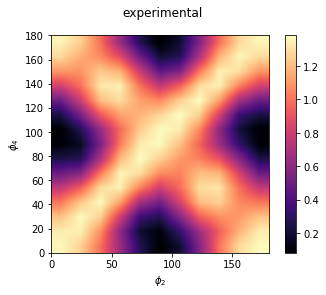

In [9]:
I_experimental=experimental_dict['intensities']
dibujar_2d_fitting(angles_2_e, angles_3_e, I_experimental, title='experimental')
I_experimental = np.transpose(I_experimental)

## Using last parameters for BS, P and R

I will use the parameters for beam splitter, polarizer and retarder obtained in Paso5. If it works, we can use those values in our experiment. Retarder initial angles will be parameters, as well as the maximum intensity.

Fit parameters: Th0r1 = 41.5412854726; Th0r2 = 136.520645045; Ei = 1.23488785878;


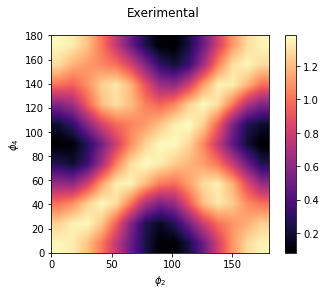

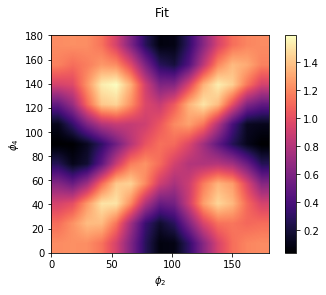

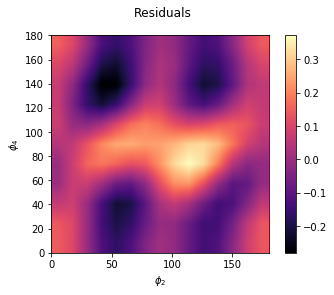

In [12]:
# Initial parameters:
Jp1 = pj.real_polarizer(P1 = 1.07, P2 = 0.146, theta = 94.7*degrees)
Jp2 = pj.real_polarizer(P1 = 1.07, P2 = 0.146, theta = 93.8*degrees)
Jr = pj.diattenuator_retarder(delta = 94.9*degrees, A = 1.0243, B = 1.003)    
Jbs = pj.diattenuator_retarder(delta = 2.1*degrees, A = 0.928, B = 1.210)
par0 = [0, 0, 1.35]
# Optimization function
def model_func2D(par, th1, th2): 
    J = [Jp1, Jr, Jbs, Jr, Jp2]
    th = [0, th1-par[0], 0, th2-par[1], 0]
    I = Intensity_Rotating_Elements(J, th, par[2])
    return I
def err_func2D(par, th1, th2, y): 
    dI = model_func2D(par, th1, th2) - y 
    return dI.flatten()
# Optimize
par1, success = optimize.leastsq(err_func2D, par0, args=(angles_2_e, angles_3_e, I_experimental))
# Print results
print('Fit parameters: Th0r1 = {}; Th0r2 = {}; Ei = {};'.format(
        (par1[0]/degrees)%180, (par1[1]/degrees)%180, par1[2] ))
#par1[3] = 45*degrees
#par1 = [1, 1, pi/2, pi/4]
I_fitting = model_func2D(par1, angles_2_e, angles_3_e)
residuals = I_experimental - I_fitting
dibujar_2d_fitting(angles_2_e, angles_3_e, I_experimental, title='Exerimental')
dibujar_2d_fitting(angles_2_e, angles_3_e, I_fitting, title='Fit')
dibujar_2d_fitting(angles_2_e, angles_3_e, residuals, title='Residuals')

It's not working. Let´s see if we introduce the most unknown parameter from the beam splitter as parameter if the result is better.

Fit parameters: Th0r1 = 41.1578202815; Th0r2 = 136.244980108; Ei = 1.49418887118; Bbs = 0.970258499935


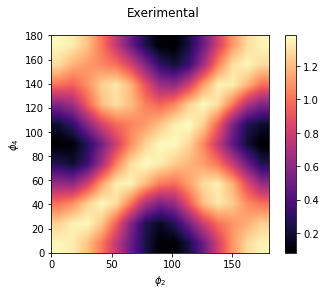

In [15]:
# Initial parameters:
Jp1 = pj.real_polarizer(P1 = 1.07, P2 = 0.146, theta = 94.7*degrees)
Jp2 = pj.real_polarizer(P1 = 1.07, P2 = 0.146, theta = 93.8*degrees)
Jr = pj.diattenuator_retarder(delta = 94.9*degrees, A = 1.0243, B = 1.003)    
par0 = [0, 0, 1.35, 1.2]
# Optimization function
def model_func2D(par, th1, th2): 
    Jbs = pj.diattenuator_retarder(delta = 2.1*degrees, A = 0.928, B = par[3])
    J = [Jp1, Jr, Jbs, Jr, Jp2]
    th = [0, th1-par[0], 0, th2-par[1], 0]
    I = Intensity_Rotating_Elements(J, th, par[2])
    return I
def err_func2D(par, th1, th2, y): 
    dI = model_func2D(par, th1, th2) - y 
    return dI.flatten()
# Optimize
par1, success = optimize.leastsq(err_func2D, par0, args=(angles_2_e, angles_3_e, I_experimental))
# Print results
print('Fit parameters: Th0r1 = {}; Th0r2 = {}; Ei = {}; Bbs = {}'.format(
        (par1[0]/degrees)%180, (par1[1]/degrees)%180, par1[2], par1[3] ))
#par1[3] = 45*degrees
#par1 = [1, 1, pi/2, pi/4]
I_fitting = model_func2D(par1, angles_2_e, angles_3_e)
residuals = I_experimental - I_fitting
dibujar_2d_fitting(angles_2_e, angles_3_e, I_experimental, title='Exerimental')
dibujar_2d_fitting(angles_2_e, angles_3_e, I_fitting, title='Fit')
dibujar_2d_fitting(angles_2_e, angles_3_e, residuals, title='Residuals')

Much better. Use starting angles also as parameters?

Fit parameters: Th0r1 = 166.39451061; Th0r2 = 80.4889378293; Ei = 1.573380279; Bbs = 0.888507370623; Th0p1 = 148.908549739; Th0p2 = 149.393296368;


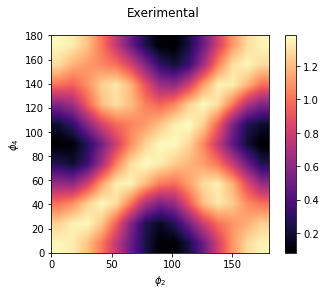

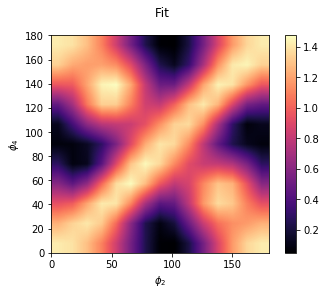

In [16]:
# Initial parameters:
Jp1 = pj.real_polarizer(P1 = 1.07, P2 = 0.146, theta = 0)
Jp2 = pj.real_polarizer(P1 = 1.07, P2 = 0.146, theta = 0)
Jr = pj.diattenuator_retarder(delta = 94.9*degrees, A = 1.0243, B = 1.003)    
par0 = [45*degrees, 135*degrees, 1.35, 1.2, 94.7*degrees, 93.8*degrees]
# Optimization function
def model_func2D(par, th1, th2): 
    Jbs = pj.diattenuator_retarder(delta = 2.1*degrees, A = 0.928, B = par[3])
    J = [Jp1, Jr, Jbs, Jr, Jp2]
    th = [par[4], th1-par[0], 0, th2-par[1], par[5]]
    I = Intensity_Rotating_Elements(J, th, par[2])
    return I
def err_func2D(par, th1, th2, y): 
    dI = model_func2D(par, th1, th2) - y 
    return dI.flatten()
# Optimize
par1, success = optimize.leastsq(err_func2D, par0, args=(angles_2_e, angles_3_e, I_experimental))
# Print results
print('Fit parameters: Th0r1 = {}; Th0r2 = {}; Ei = {}; Bbs = {}; Th0p1 = {}; Th0p2 = {};'.format(
        (par1[0]/degrees)%180, (par1[1]/degrees)%180, par1[2], par1[3], (par1[4]/degrees)%180, (par1[5]/degrees)%180 ))
#par1[3] = 45*degrees
#par1 = [1, 1, pi/2, pi/4]
I_fitting = model_func2D(par1, angles_2_e, angles_3_e)
residuals = I_experimental - I_fitting
dibujar_2d_fitting(angles_2_e, angles_3_e, I_experimental, title='Exerimental')
dibujar_2d_fitting(angles_2_e, angles_3_e, I_fitting, title='Fit')
dibujar_2d_fitting(angles_2_e, angles_3_e, residuals, title='Residuals')

Not better, so I will ignore this angles and stick to the older ones which I trust more. So let's try to fit retarder parameters instead.

Fit parameters: Th0r1 = 41.1544396615; Th0r2 = 136.032408142; Ei = 1.22958104592; Bbs = 0.890507898643
Fit parameters for retarder: A = 1.14176947772; B = 1.14313202396; delta = 43.6500061081;


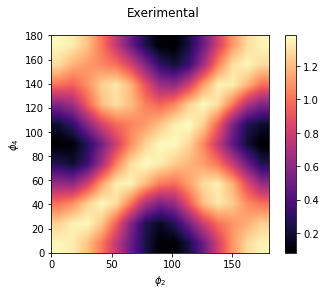

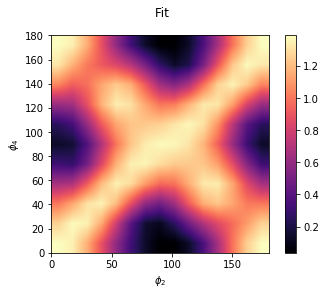

In [21]:
# Initial parameters:
Jp1 = pj.real_polarizer(P1 = 1.07, P2 = 0.146, theta = 94.7*degrees)
Jp2 = pj.real_polarizer(P1 = 1.07, P2 = 0.146, theta = 93.8*degrees)

par0 = [0, 0, 1.35, 1.2, 1, 1, 90*degrees]
# Optimization function
def model_func2D(par, th1, th2): 
    Jbs = pj.diattenuator_retarder(delta = 2.1*degrees, A = 0.928, B = par[3])
    Jr = pj.diattenuator_retarder(delta = par[6]*degrees, A = par[4], B = par[5])    
    J = [Jp1, Jr, Jbs, Jr, Jp2]
    th = [0, th1-par[0], 0, th2-par[1], 0]
    I = Intensity_Rotating_Elements(J, th, par[2])
    return I
def err_func2D(par, th1, th2, y): 
    dI = model_func2D(par, th1, th2) - y 
    return dI.flatten()
# Optimize
par1, success = optimize.leastsq(err_func2D, par0, args=(angles_2_e, angles_3_e, I_experimental))
# Print results
print('Fit parameters: Th0r1 = {}; Th0r2 = {}; Ei = {}; Bbs = {}'.format(
        (par1[0]/degrees)%180, (par1[1]/degrees)%180, par1[2], par1[3] ))
print('Fit parameters for retarder: A = {}; B = {}; delta = {};'.format(
        par1[4], par1[5], (par1[6]/degrees)%180))
#par1[3] = 45*degrees
#par1 = [1, 1, pi/2, pi/4]
I_fitting = model_func2D(par1, angles_2_e, angles_3_e)
residuals = I_experimental - I_fitting
dibujar_2d_fitting(angles_2_e, angles_3_e, I_experimental, title='Exerimental')
dibujar_2d_fitting(angles_2_e, angles_3_e, I_fitting, title='Fit')
dibujar_2d_fitting(angles_2_e, angles_3_e, residuals, title='Residuals')

Slightly better but unbeliebable. Let's try to improve by fitting everything in BS.

Fit parameters: Th0r1 = 41.2867920471; Th0r2 = 136.279751414; Ei = 0.133318255534;
Fit parameters for the beam splitter: A = 10.413060521; B = 10.8722818779; delta = 7.77649536217º;


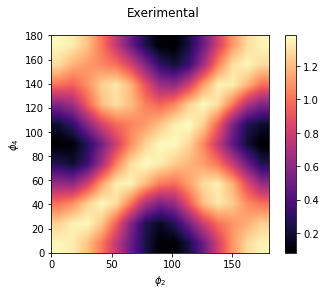

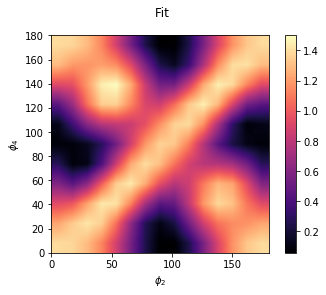

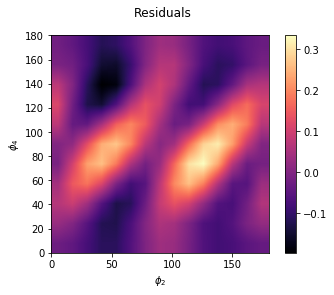

In [23]:
# Initial parameters:
Jp1 = pj.real_polarizer(P1 = 1.07, P2 = 0.146, theta = 94.7*degrees)
Jp2 = pj.real_polarizer(P1 = 1.07, P2 = 0.146, theta = 93.8*degrees)
Jr = pj.diattenuator_retarder(delta = 94.9*degrees, A = 1.0243, B = 1.003)    
par0 = [0, 0, 1.35, 0.93, 1.2, 2.1*degrees]
# Optimization function
def model_func2D(par, th1, th2): 
    Jbs = pj.diattenuator_retarder(delta = par[5]*degrees, A = par[3], B = par[4])
    J = [Jp1, Jr, Jbs, Jr, Jp2]
    th = [0, th1-par[0], 0, th2-par[1], 0]
    I = Intensity_Rotating_Elements(J, th, par[2])
    return I
def err_func2D(par, th1, th2, y): 
    dI = model_func2D(par, th1, th2) - y 
    return dI.flatten()
# Optimize
par1, success = optimize.leastsq(err_func2D, par0, args=(angles_2_e, angles_3_e, I_experimental))
# Print results
print('Fit parameters: Th0r1 = {}; Th0r2 = {}; Ei = {};'.format(
        (par1[0]/degrees)%180, (par1[1]/degrees)%180, par1[2] ))
print('Fit parameters for the beam splitter: A = {}; B = {}; delta = {}º;'.format(
        par1[3], par1[4], (par1[5]/degrees)%180 ))
#par1[3] = 45*degrees
#par1 = [1, 1, pi/2, pi/4]
I_fitting = model_func2D(par1, angles_2_e, angles_3_e)
residuals = I_experimental - I_fitting
dibujar_2d_fitting(angles_2_e, angles_3_e, I_experimental, title='Exerimental')
dibujar_2d_fitting(angles_2_e, angles_3_e, I_fitting, title='Fit')
dibujar_2d_fitting(angles_2_e, angles_3_e, residuals, title='Residuals')

And the solution is not here.

## Fitting to matrices: solo angulos


In [5]:
param_u0, u0 =get_light_parameters()
[amplitude, angle, phase]=param_u0
print(u0)

[[ 3.5431]
 [-0.0246]
 [ 0.0126]
 [ 3.5429]]


In [6]:
pol_dicts =get_polarimeter_parameters(kind='exp')
p1,p2,p3,p4=pol_dicts
pprint.pprint(pol_dicts)

[{'p0': 0.128068490426,
  'p1': 0.934950416021,
  'theta_axis': 0.048659779545601904},
 {'a': 1,
  'b': 1,
  'delta': 1.3854423602330987,
  'theta_axis': 0.7780084393445043},
 {'a': 1,
  'b': 1,
  'delta': 1.3854423602330987,
  'theta_axis': 2.2996981823052884},
 {'p0': 0.128068490426,
  'p1': 0.934950416021,
  'theta_axis': 2.8253389931284207}]


In [7]:
def get_intensity_numerical_angulos(par_fitting, angles_2, angles_3, u0):
    """
    par_fitting son los parámetros de optimización, en este caso
        angle_1, angle_2, angle_4, p1, p0, a, b, delta=par_fitting
    """
    
    angle_1_pol, angle_2_pol, angle_3_pol, angle_4_pol=par_fitting

    p0_best = 0.128068490426
    p1_best = 0.934950416021
    phase_best = 78.38*degrees
    
    P1=polarizer_linear(p1=p1_best, p2=p0_best, theta=0)
    P2=diattenuating_retarder(p1=1, p2=1, phase=phase_best, theta=angle_2_pol)
    P3=diattenuating_retarder(p1=1, p2=1, phase=phase_best, theta=angle_3_pol)
    P4=polarizer_linear(p1=p1_best, p2=p0_best, theta=angle_4_pol)
      
    Angles_2, Angles_3 = sp.meshgrid(angles_2, angles_3)
    intensity_numerical=sp.zeros_like(Angles_2, dtype=float)

    for i2, angle_2 in enumerate(angles_2):
        P2_r =rotate_mueller(P2, angle_2)
        for i3, angle_3 in enumerate(angles_3):
            P3_r =rotate_mueller(P3, angle_3)
            intensity_numerical[i3,i2]=intensity(P4*P3_r*P2_r*P1*u0)
            
    return intensity_numerical

In [8]:
def err_func3(par_error, angles_2, angles_3, u0,I_experimental):
    I_theory=get_intensity_numerical_angulos(par_error, angles_2, angles_3, u0)
    factor_intensidad=I_experimental.max()/I_theory.max()
    I_theory = I_theory*factor_intensidad

    return (abs(I_theory -I_experimental).flatten())

has_example=False
if has_example:
    params_3_ini=np.array([0*degrees, 45*degrees, 45*degrees, 90*degrees])
    error=err_func3(params_3_ini, angles_2_e, angles_3_e, u0,I_experimental)
    I_ini_3=get_intensity_numerical_angulos(params_3_ini, angles_2_e, 
                                       angles_3_e, u0)
    dibujar_2d_fitting(angles_2_e, angles_3_e, I_ini_3, 'inicial')
    print(error.mean())

In [9]:
params_3_ini=np.array([0*degrees, 45*degrees, 130*degrees,  0*degrees])
params_3_fin, success = optimize.leastsq(err_func3, params_3_ini,args=(angles_2_e, angles_3_e, u0, I_experimental))

In [10]:
print("""theta_1 = {:4.6}º, 
theta_2 = {:4.6}º, 
theta_3 = {:4.6}º, 
theta_4 = {:4.6}º""".format(params_3_fin[0]/degrees, 
                    params_3_fin[1]/degrees,params_3_fin[2]/degrees,params_3_fin[3]/degrees))

theta_1 =  0.0º, 
theta_2 = 43.6046º, 
theta_3 = 126.52º, 
theta_4 = -3.37835º


In [13]:
print(sp.remainder(params_3_fin, 2*sp.pi)/degrees)

[   0.       43.6046  126.5201  356.6216]


1.01230615845
0.0776404706007


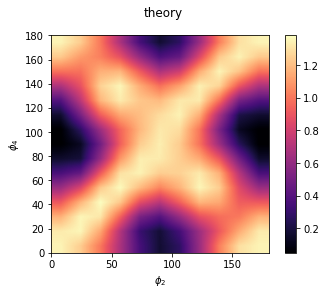

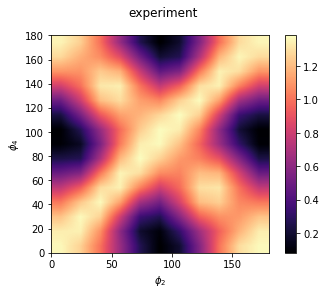

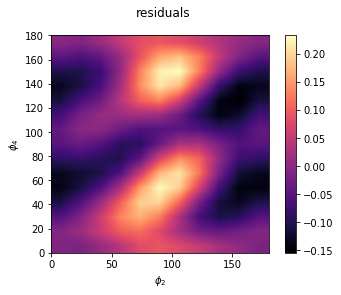

In [12]:
I_best3=get_intensity_numerical_angulos(params_3_fin, angles_2_e, 
                                       angles_3_e, u0)

factor_intensidad=I_experimental.max()/I_best3.max()
I_best3 = I_best3*factor_intensidad
residuals=I_best3-I_experimental

dibujar_2d_fitting(angles_2_e, angles_3_e, I_best3, 'theory')
dibujar_2d_fitting(angles_2_e, angles_3_e, I_experimental,'experiment')
dibujar_2d_fitting(angles_2_e, angles_3_e, residuals, 'residuals')
print(factor_intensidad)
print(sp.mean(abs(residuals)))